In [1]:
import numpy as np
import scipy.integrate as intg
import scipy.optimize as opt
import scipy.special as spc
import scipy.stats as sts
import matplotlib.pyplot as plt

data = np.loadtxt('clms.txt')
data_800 = data[data<=800]

In [2]:
# 1(a) Descriptive Statistics
print('mean = ', np.mean(data))
print('median = ', np.median(data))
print('maximum = ', max(data))
print('minimum = ', min(data))
print('standard deviation = ', np.std(data))

mean =  720.277975327
median =  172.21
maximum =  227967.25
minimum =  0.01
standard deviation =  3972.66375639


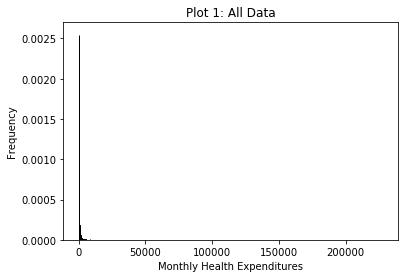

In [3]:
# 1(a) Plot 1: All Data
obs1, bins1, patches1 = plt.hist(data, 1000, normed = True, edgecolor = 'black')
plt.ylim([0, 0.0027])
plt.xlabel('Monthly Health Expenditures')
plt.ylabel('Frequency')
plt.title('Plot 1: All Data')
plt.show()

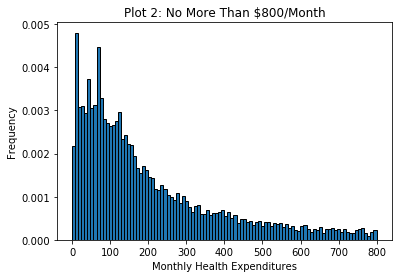

0.849420849421


In [5]:
# Plot 2: <= $800, accounted for all data available
obs2, bins2, patches2 = plt.hist(data_800, 100, weights = (np.ones_like(data_800)/len(data))/8, edgecolor = 'black')
plt.xlabel('Monthly Health Expenditures')
plt.ylabel('Frequency')
plt.title('Plot 2: No More Than $800/Month')
plt.show()
print(obs2.sum()*8)
# Note that the total frequency in this figure is less than 1 (around 0.85), 
# since we have accounted for the data not shown.
# Comparing two plots, I would prefer the second one. 
# Given that the data has extreme outliers, the first plot loses much information about the claims around zero. 
# However, the second plot depicts the distribution within the interval 
# where the majority of data (85%) is concentrated. This makes the second plot more informative.

In [6]:
# 1(b) Calculation
# Define Gamma pdf
def gamma_pdf(xvals, alpha, beta):
    pdf_vals = xvals**(alpha-1) * (np.exp(-xvals/beta)) / (spc.gamma(alpha) * beta**alpha) 
    return pdf_vals

# Define log Likelihood function of Gamma
def log_lik_gamma(xvals, alpha, beta):
    pdf_vals = gamma_pdf(xvals, alpha, beta)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_val = log_pdf_vals.sum()
    return log_lik_val

# Criterion Function
def crit(params, args):
    alpha, beta = params
    xvals = args
    log_lik_val = log_lik_gamma(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

# Initial Guesses
beta_init = np.var(data)/np.mean(data)
alpha_init = np.mean(data)/beta_init
params_init = np.array([alpha_init, beta_init])

params_bounds = ((1e-10, None), (1e-10, None))

# Gamma Estimation, all data
result = opt.minimize(crit, params_init, args=data, bounds = params_bounds, method = 'L-BFGS-B')
alpha_mle, beta_mle = result.x

log_lik_mle = log_lik_gamma(data, alpha_mle, beta_mle)

print('Initial Alpha = ', alpha_init)
print('Initial Beta = ', beta_init)
print('MLE Alpha = ', alpha_mle)
print('MLE Beta = ', beta_mle)
print('MLE Log Likelihood = ', log_lik_mle)

# FYI, if I estimate using data<=800, the results are
beta_init_800 = np.var(data_800)/np.mean(data_800)
alpha_init_800 = np.mean(data_800)/beta_init_800
params_init_800 = np.array([alpha_init_800, beta_init_800])

result_800 = opt.minimize(crit, params_init_800, args = data_800, bounds = params_bounds, method = 'L-BFGS-B')
alpha_mle_800, beta_mle_800 = result_800.x
log_lik_mle_800 = log_lik_gamma(data_800, alpha_mle_800, beta_mle_800)

print('- Estimating using data<=800:')
print('Initial Alpha = ', alpha_init_800)
print('Initial Beta = ', beta_init_800)
print('MLE Alpha = ', alpha_mle_800)
print('MLE Beta = ', beta_mle_800)
print('MLE Log Likelihood = ', log_lik_mle_800)

Initial Alpha =  0.0328727966942
Initial Beta =  21911.0647028
MLE Alpha =  0.221755322727
MLE Beta =  21911.0646992
MLE Log Likelihood =  -82076.4516057
- Estimating using data<=800:
Initial Alpha =  1.18831402854
Initial Beta =  167.723283979
MLE Alpha =  1.13976370528
MLE Beta =  174.867844994
MLE Log Likelihood =  -56732.5986794


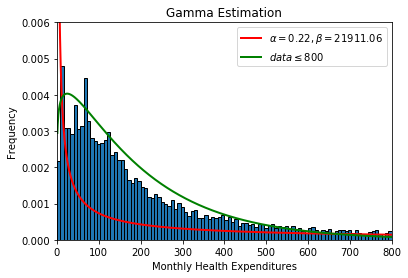

In [7]:
# 1(b) Plot
pts = np.linspace(1, 800, 1000)
plt.hist(data_800, 100, weights = (np.ones_like(data_800)/len(data))/8, edgecolor = 'black')
plt.plot(pts, gamma_pdf(pts, alpha_mle, beta_mle), linewidth = 2, color = 'r', label = r'$\alpha={}, \beta={}$'.format(round(alpha_mle,2),round(beta_mle,2)))
plt.plot(pts, gamma_pdf(pts, alpha_mle_800, beta_mle_800), linewidth = 2, color = 'g', label = r'$data \leq 800$')
plt.legend(loc='upper right')
plt.xlabel('Monthly Health Expenditures')
plt.ylabel('Frequency')
plt.title('Gamma Estimation')
plt.xlim([0,800])
plt.ylim([0,0.006])
plt.show()

In [8]:
# 1(c) Calculation
def gengamma_pdf(xvals, alpha, beta, m):
    pdf_vals = m*xvals**(alpha-1)*(np.exp(-(xvals/beta)**m)/(spc.gamma(alpha/m)*beta**alpha))    
    return pdf_vals

def log_lik_gengamma(xvals, alpha, beta, m):
    pdf_vals = gengamma_pdf(xvals, alpha, beta, m)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_val = log_pdf_vals.sum()
    return log_lik_val

def crit_gg(params, args):
    alpha, beta, m = params
    xvals = args
    log_lik_val = log_lik_gengamma(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

m = 0.99
params_init_gg = np.array([alpha_mle, beta_mle, m])
params_bounds_gg = ((1e-10, None), (1e-10, None), (1e-10, None))

result_gg = opt.minimize(crit_gg, params_init_gg, args=data, bounds = params_bounds_gg, method = 'L-BFGS-B')
alpha_mle_gg, beta_mle_gg, m_mle_gg = result_gg.x

log_lik_mle_gg = log_lik_gengamma(data, alpha_mle_gg, beta_mle_gg, m_mle_gg)

print('MLE Alpha GG = ', alpha_mle_gg)
print('MLE Beta GG= ', beta_mle_gg)
print('MLE m GG= ', m_mle_gg)
print('MLE Log Likelihood GG = ', log_lik_mle_gg)

MLE Alpha GG =  0.221753918293
MLE Beta GG=  21911.0646501
MLE m GG=  0.997652301706
MLE Log Likelihood GG =  -82076.4464883


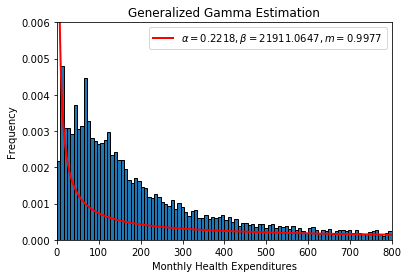

In [9]:
# 1(c) Plot
plt.hist(data_800, 100, weights = (np.ones_like(data_800)/len(data))/8, edgecolor = 'black')
plt.plot(pts, gengamma_pdf(pts, alpha_mle_gg, beta_mle_gg, m_mle_gg), linewidth = 2, color = 'r', label = r'$\alpha={}, \beta={}, m={}$'.format(round(alpha_mle_gg,4),round(beta_mle_gg,4),round(m_mle_gg,4)))
plt.legend(loc='upper right')
plt.xlabel('Monthly Health Expenditures')
plt.ylabel('Frequency')
plt.title('Generalized Gamma Estimation')
plt.xlim([0,800])
plt.ylim([0,0.006])
plt.show()

In [11]:
# 1(d) Calculation
def beta2_pdf(xvals, a, b, p, q):
    pdf_vals = a*xvals**(a*p-1)/(b**(a*p)*(1+(xvals/b)**a)**(p+q)*spc.beta(p,q))
    return pdf_vals

def log_lik_beta2(xvals, a, b, p, q):
    pdf_vals = beta2_pdf(xvals, a, b, p, q)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_val = log_pdf_vals.sum()
    return log_lik_val

def crit_beta2(params, args):
    a, b, p, q = params
    xvals = args
    log_lik_val = log_lik_beta2(xvals, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

a = m_mle_gg
q = 10000
b = (q**(1/a))*beta_mle_gg
p = alpha_mle_gg/a

params_init_b2 = np.array([a,b,p,q])
params_bounds_b2 = ((1e-10, None), (1e-10, None), (1e-10, None), (1e-10, None))

result_b2 = opt.minimize(crit_beta2, params_init_b2, args=data, bounds = params_bounds_b2, method = 'L-BFGS-B')
a_mle, b_mle, p_mle, q_mle = result_b2.x

log_lik_mle_b2 = log_lik_beta2(data, a_mle, b_mle, p_mle, q_mle)

print('Initial a = ', a)
print('Initial b = ', b)
print('Initial p = ', p)
print('Initial q = ', q)
print('Beta 2 MLE a = ', a_mle)
print('Beta 2 MLE b = ', b_mle)
print('Beta 2 MLE p = ', p_mle)
print('Beta 2 MLE q = ', q_mle)
print('Beta 2 MLE Log Likelihood = ', log_lik_mle_b2)

Initial a =  0.997652301706
Initial b =  223911485.95
Initial p =  0.222275754704
Initial q =  10000
Beta 2 MLE a =  0.699552036032
Beta 2 MLE b =  223911485.95
Beta 2 MLE p =  0.994908095828
Beta 2 MLE q =  9998.76316539
Beta 2 MLE Log Likelihood =  -76461.4674714


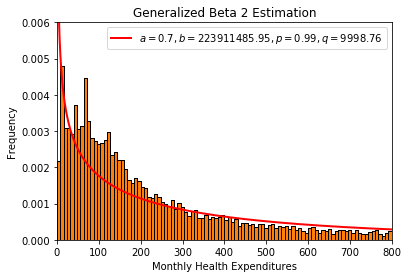

In [12]:
# 1(d) Plot
plt.hist(data_800, 100, weights = (np.ones_like(data_800)/len(data))/8, edgecolor = 'black')
plt.plot(pts, beta2_pdf(pts, a_mle, b_mle, p_mle, q_mle), linewidth = 2, color = 'r', label = r'$a={}, b={}, p={}, q={}$'.format(round(a_mle,2), round(b_mle,2), round(p_mle,2), round(q_mle,2)))
plt.legend(loc='upper right')
plt.xlabel('Monthly Health Expenditures')
plt.ylabel('Frequency')
plt.title('Generalized Beta 2 Estimation')
plt.xlim([0,800])
plt.ylim([0,0.006])
plt.show()

In [13]:
# 1(e) LR Tests
lr_ga = 2 * (log_lik_mle_b2 - log_lik_mle)
lr_gg = 2 * (log_lik_mle_b2 - log_lik_mle_gg)
print('LR for Gamma:', lr_ga)
print('LR for Generalized Gamma:', lr_gg)

LR for Gamma: 11229.9682684
LR for Generalized Gamma: 11229.9580337


In [14]:
# 1(e) p-values
pval_ga = 1 - sts.chi2.cdf(lr_ga, 4)
pval_gg = 1 - sts.chi2.cdf(lr_gg, 4)
print('p-value for LR test, GA = ', pval_ga)
print('p-value for LR test, GG = ', pval_gg)

p-value for LR test, GA =  0.0
p-value for LR test, GG =  0.0


In [15]:
# 1(f) Probability Calculation
prob_b2 = round(1 - intg.quad(lambda x: beta2_pdf(x, a_mle, b_mle, p_mle, q_mle), 0, 1000)[0],5)
prob_ga = round(1 - intg.quad(lambda x: gamma_pdf(x, alpha_mle, beta_mle), 0, 1000)[0],5)
print('Probability of monthly health care claim above $1000 with GB2 distribution = ', prob_b2)
print('Probability of monthly health care claim above $1000 with GA distribution = ', prob_ga)

Probability of monthly health care claim above $1000 with GB2 distribution =  0.16265
Probability of monthly health care claim above $1000 with GA distribution =  0.45196
